In [1]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)


In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

2024-05-25 23:47:24.868674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def read_image(file_path):
    rgb_image = cv2.imread(file_path)
    return rgb_image

In [4]:
X = []
y = []

df = pd.read_csv('irmas_novoice.csv')
dataset_path = "IRMAS_Train"
for index, row in tqdm(df.iterrows()):
    file_path = os.path.join(dataset_path, row["filename"].split(".")[0] + ".jpg").replace("\\", "/")
    image_rgb_matrix = read_image(file_path)
    image_rgb_matrix = image_rgb_matrix.astype('float32') / 255.0 # NORMALIZE RGB VALUES IN [0,1]
    label = row["label"]
    X.append(image_rgb_matrix)
    y.append(label)
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

5927it [00:06, 896.24it/s] 


(5927, 130, 128, 3)
(5927,)


In [5]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
len(labelencoder.classes_)

# To see the mapping, you can create a dictionary using the classes_ attribute
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

print("Label Mapping:", label_mapping)

Label Mapping: {'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4, 'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4741, 130, 128, 3)
(4741,)
(1186, 130, 128, 3)
(1186,)


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(130, 128, 3))
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-25:]:
    layer.trainable = True

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
optimizer = Adam(learning_rate=0.00001)
model.summary()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
model.save('irmas_resnet.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 10,517,258
Non-trainable params: 13,597,568
_________________________________

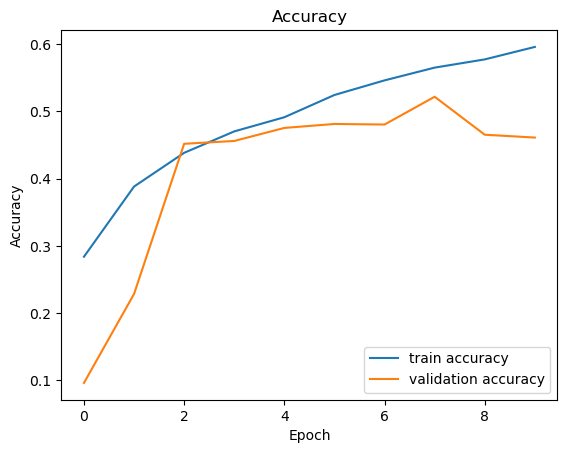

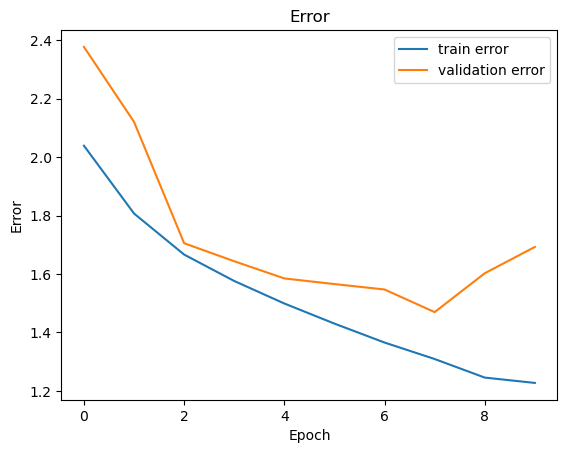

In [12]:
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.savefig("irmas_rn50_acc.png")
plt.show()

plt.figure(2)
plt.plot(history.history["loss"], label="train error")
plt.plot(history.history["val_loss"], label="validation error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error")
plt.savefig("irmas_rn50_loss.png")
plt.show()